In [1]:
#基于lstm量化交易系统
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from pandas_datareader import data as pdr
import datetime
import yfinance as yf


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#配置火币API
from HuobiDMService import HuobiDM
from pprint import pprint

# 输入火币合约交易的api地址
URL = 'https://api.btcgateway.pro'

#  输入 access_key 和 secret_key :
ACCESS_KEY = 'ht4tgq1e4t-193badb4-e7e7cf3c-4ee66'
SECRET_KEY = 'adc3cfec-6d3eeae3-e6fe0285-88243'


dm = HuobiDM(URL, ACCESS_KEY, SECRET_KEY)

In [3]:
#配置matplotlib画图的符号
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文
plt.rcParams['axes.unicode_minus']=False #用来正常显示坐标中的负号

def get_stock_data(name):
    try:
        yf.pdr_override()
    #实时股票数据
        finance = pdr.get_data_yahoo(name,start = datetime.datetime(2014,11,11),end = datetime.datetime(2020,3,11))  
        data = np.array(finance['Close']) #获取收盘价的数据
        data = data[::1] #获取这列的所有数据
        print('股票数据获取完成！！')
        return data
    except Exception:
        print('股票数据获取失败！！')
def get_coin_data(name):
    try:
        finance = pd.DataFrame(dm.get_contract_kline(symbol=name, period='1day', size=2000)['data'])
        data = np.array(finance['close']) #获取收盘价的数据
        data = data[::1] #获取这列的所有数据
        print(data)
        print('数据获取完成！！')
        return data
    except Exception:
        print('数据获取失败！！')


In [4]:
data = get_coin_data('BTC_CW')
#以折线图展示导入的数据
fig =plt.figure()
#fig.add_subplot(1,2,1)
#plt.plot(data)
#plt.show()
normalize_data=(data-np.mean(data))/np.std(data)  #对数据进行标准化 （数据 - 均值）/（方差）
normalize_data=normalize_data[:,np.newaxis]       #增加数据的维度，使数据维度相同

[ 3673.24  3805.6   3826.47  3743.52  3820.    3814.17  4012.03  4030.48
  3991.2   3778.62  3620.29  3618.98  3606.23  3658.67  3625.29  3606.59
  3602.06  3610.94  3695.67  3508.98  3526.7   3569.14  3549.34  3553.29
  3553.    3548.15  3540.56  3412.05  3407.15  3440.48  3418.16  3431.66
  3423.42  3421.43  3411.38  3419.68  3375.92  3365.48  3455.75  3610.27
  3597.7   3603.36  3573.34  3564.71  3568.8   3558.    3599.67  3576.99
  3810.37  3957.77  3911.89  3904.59  3940.07  3933.33  3776.01  3795.59
  3806.63  3797.43  3842.08  3815.52  3801.01  3786.68  3701.63  3824.62
  3849.49  3864.54  3887.85  3918.9   3886.67  3832.08  3848.41  3849.2
  3858.05  3899.37  3978.36  3969.55  3963.43  3981.93  3997.    3966.58
  3980.26  3980.32  3971.35  3945.    3912.5   4006.08  4007.    4074.52
  4060.9   4076.2   4127.68  4752.68  5014.79  5007.22  5002.72  5115.
  5142.82  5246.67  5219.11  5283.72  5034.84  5079.2   5079.7   5078.35
  5162.1   5088.81  5204.5   5253.16  5279.1   5310.17

<Figure size 432x288 with 0 Axes>

In [5]:
#———————————————————形成训练集—————————————————————
#设置rnn网络的常量
time_step=20     #时间步 ，rnn每迭代20次，就向前推进一步
rnn_unit=10       # hidden layer units
batch_size=60     # 每一批训练多少个样例
input_size=1      # 输入层数维度
output_size=1     # 输出层数维度
lr=0.0006         # 学习率
train_x,train_y=[],[]   #训练集
for i in range(len(normalize_data)-time_step-1):
    x=normalize_data[i:i+time_step]
    y=normalize_data[i+1:i+time_step+1]
    train_x.append(x.tolist())
    train_y.append(y.tolist()) 
# print(len(normalize_data))
# print(train_x)
# print(train_y)

In [6]:
#———————————————————定义神经网络变量—————————————————————

X=tf.placeholder(tf.float32, [None,time_step,input_size])    #每批次输入网络的tensor
Y=tf.placeholder(tf.float32, [None,time_step,output_size])   # 每批次tensor对应的标签
#输入层、输出层的权重和偏置
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
        }

In [7]:
#———————————————————定义lstm网络—————————————————————
def lstm(batch):      #参数：输入网络批次数目
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转为2维进行计算，计算后的结果作为 隐藏层的输入
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])   #将tensor转为3维，作为 lstm cell的输入
    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)
    output=tf.reshape(output_rnn,[-1,rnn_unit])  #作为输出层的输入
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states



In [8]:
#———————————————————对模型进行训练—————————————————————
def train_lstm():
    global batch_size
    with tf.variable_scope("sec_lstm"):
        pred,_=lstm(batch_size)
    #定义损失函数
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_list = [] #收集损失值
        for i in range(201): #模型训练的次数，We can increase the number of iterations to gain better result.
            step=0
            start=0
            end=start+batch_size
            while(end<len(train_x)):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[start:end],Y:train_y[start:end]})
                start+=batch_size
                end=start+batch_size
                #每训练10次保存一次参数
                if step%10==0:
                    print("Number of iterations:",i," loss:",loss_) #输出训练次数，输出损失值
                    print("model_save",saver.save(sess,'./model_save1/modle.ckpt')) #第二个参数是保存的地址，可以修改为自己本地的保存地址
                    #I run the code in windows 10,so use  'model_save1\\modle.ckpt'
                    #if you run it in Linux,please use  'model_save1/modle.ckpt'
                    loss_list.append(loss_)
                step+=1
        print("The train has finished")
        print(len(loss_list))
        sns.set_style(style = 'whitegrid') #详细参数看seaborn的API  http://seaborn.pydata.org/api.html
        #设置字体
        sns.set_context(context = 'poster',font_scale = 1)
        plt.figure(figsize = (20,20)) #图像大小为20*20英寸
        plt.plot(np.arange(0,len(loss_list)),loss_list,'+-',color = 'g')
        plt.title('Loss trend')
        plt.ylabel('Loss')


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Number of iterations: 0  loss: 4.715282
model_save ./model_save1/modle.ckpt
Number of iterations: 1  loss: 3.4759073
model_save ./model_save1/modle.ckpt
Number of iterations: 2  loss: 2.6818035
model_save ./model_save1/modle.ckpt
Number of iterations: 3  loss: 2.057043
model_save ./model_save1/modle.ckpt
Number of iterations: 4  loss: 1.5546876
model_save ./model_save1/modle.ckpt
Number of iterations: 5  loss: 1.1564989
model_save ./model_save1/modle.ckpt
Number of iterations: 6  loss: 0.85177076
model_save ./model_save1/modle.ckpt
Number of iterations: 7  loss: 0.6296503
model

Number of iterations: 91  loss: 0.04592866
model_save ./model_save1/modle.ckpt
Number of iterations: 92  loss: 0.045225874
model_save ./model_save1/modle.ckpt
Number of iterations: 93  loss: 0.04454466
model_save ./model_save1/modle.ckpt
Number of iterations: 94  loss: 0.04388407
model_save ./model_save1/modle.ckpt
Number of iterations: 95  loss: 0.043243133
model_save ./model_save1/modle.ckpt
Number of iterations: 96  loss: 0.04262106
model_save ./model_save1/modle.ckpt
Number of iterations: 97  loss: 0.042016957
model_save ./model_save1/modle.ckpt
Number of iterations: 98  loss: 0.041430045
model_save ./model_save1/modle.ckpt
Number of iterations: 99  loss: 0.040859606
model_save ./model_save1/modle.ckpt
Number of iterations: 100  loss: 0.040304825
model_save ./model_save1/modle.ckpt
Number of iterations: 101  loss: 0.03976508
model_save ./model_save1/modle.ckpt
Number of iterations: 102  loss: 0.039239712
model_save ./model_save1/modle.ckpt
Number of iterations: 103  loss: 0.0387280

Number of iterations: 195  loss: 0.015533325
model_save ./model_save1/modle.ckpt
Number of iterations: 196  loss: 0.0153949885
model_save ./model_save1/modle.ckpt
Number of iterations: 197  loss: 0.01525795
model_save ./model_save1/modle.ckpt
Number of iterations: 198  loss: 0.0151222
model_save ./model_save1/modle.ckpt
Number of iterations: 199  loss: 0.014987699
model_save ./model_save1/modle.ckpt
Number of iterations: 200  loss: 0.014854442
model_save ./model_save1/modle.ckpt
The train has finished
201


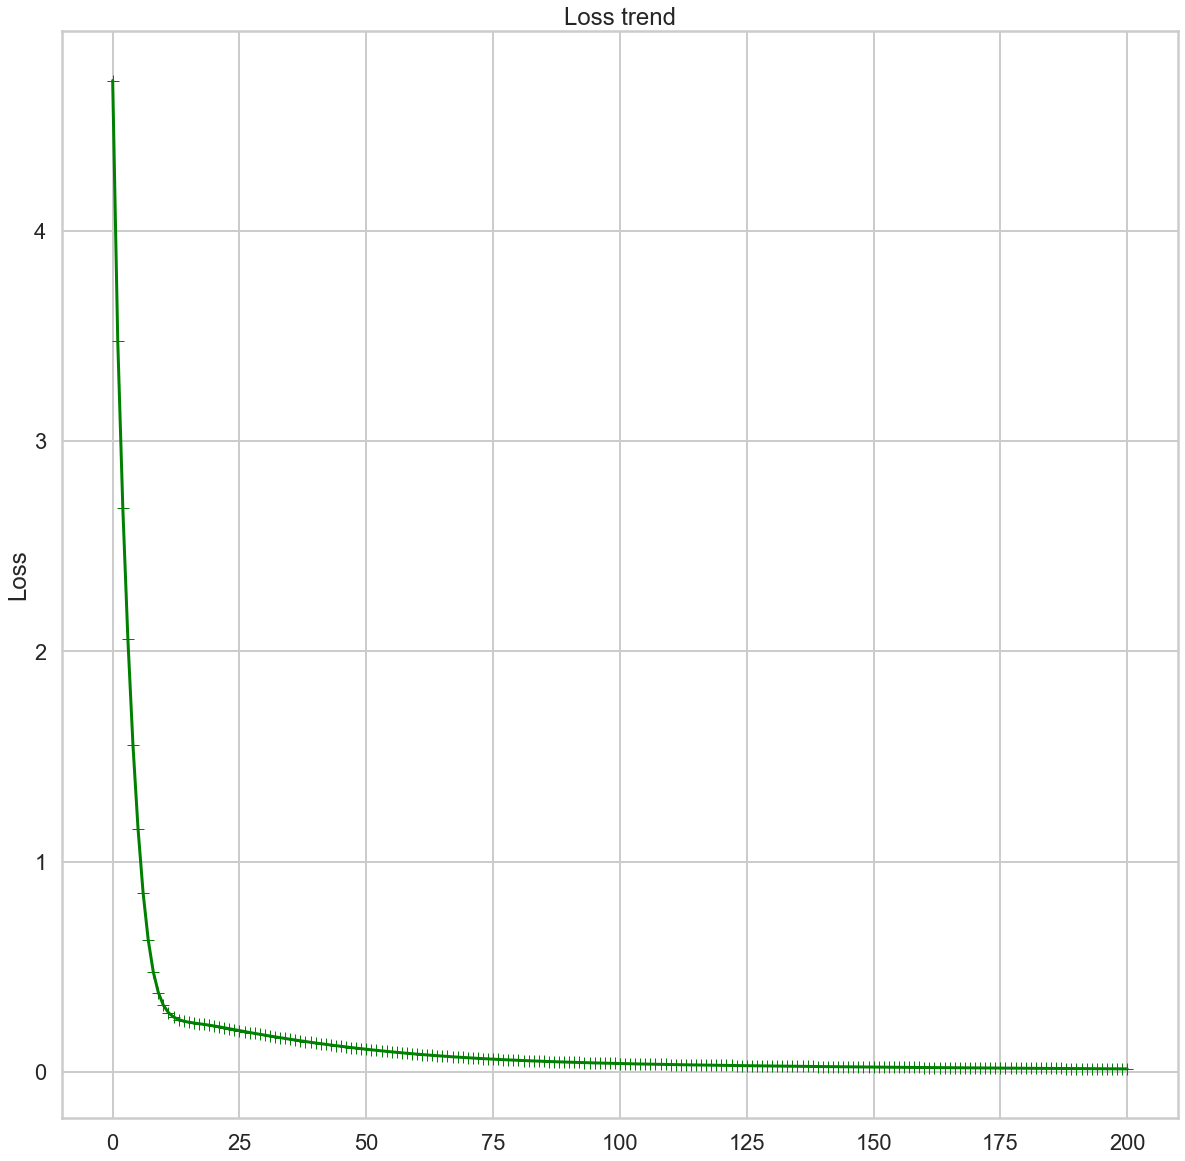

In [9]:
train_lstm() #对模型进行训练

In [10]:
#———————————————————预测模型—————————————————————
def prediction():
    with tf.variable_scope("sec_lstm",reuse=True):
        pred,_=lstm(1)    #预测时只输入[1,time_step,input_size]的测试数据
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        #参数恢复
        saver.restore(sess, './model_save1/modle.ckpt') #第二个参数是保存的地址，可以修改为自己本地的保存地址
        #I run the code in windows 10,so use  'model_save1\\modle.ckpt'
        #if you run it in Linux,please use  'model_save1/modle.ckpt'
        
        #取训练集最后一行为测试样本。shape = [1,time_step,input_size]
        prev_seq=train_x[-1]
        predict=[]
        #得到之后的100个预测结果
        for i in range(100):  #预测100个数值
            next_seq=sess.run(pred,feed_dict={X:[prev_seq]})
            predict.append(next_seq[-1])
            #每次得到最后一个时间步的预测结果，与之前的数据加在一起，形成新的测试数据
            prev_seq=np.vstack((prev_seq[1:],next_seq[-1]))
        #以折线图展示结果
        plt.figure(figsize = (20,20)) #图像大小为8*8英寸
        #设置背景风格
        sns.set_style(style = 'whitegrid') #详细参数看seaborn的API  http://seaborn.pydata.org/api.html
        #设置字体
        sns.set_context(context = 'poster',font_scale = 1)
        plt.title('lstm_rnn_stock_prediction')
        plt.plot(list(range(len(normalize_data))), normalize_data, color='b',label = 'raw data') #这是原来股票的价格走势，用蓝色曲线表示
        plt.plot(list(range(len(normalize_data), len(normalize_data) + len(predict))), predict, color='r',label = 'predict trend') #预测未来的价格走势用红色表示
        plt.legend(loc = 'best')
        plt.xlabel('stock_trend')
        plt.xticks([])#去掉X轴刻度
        plt.yticks([])
        plt.show()
#fig.add_subplot(1,2,2)       

INFO:tensorflow:Restoring parameters from ./model_save1/modle.ckpt


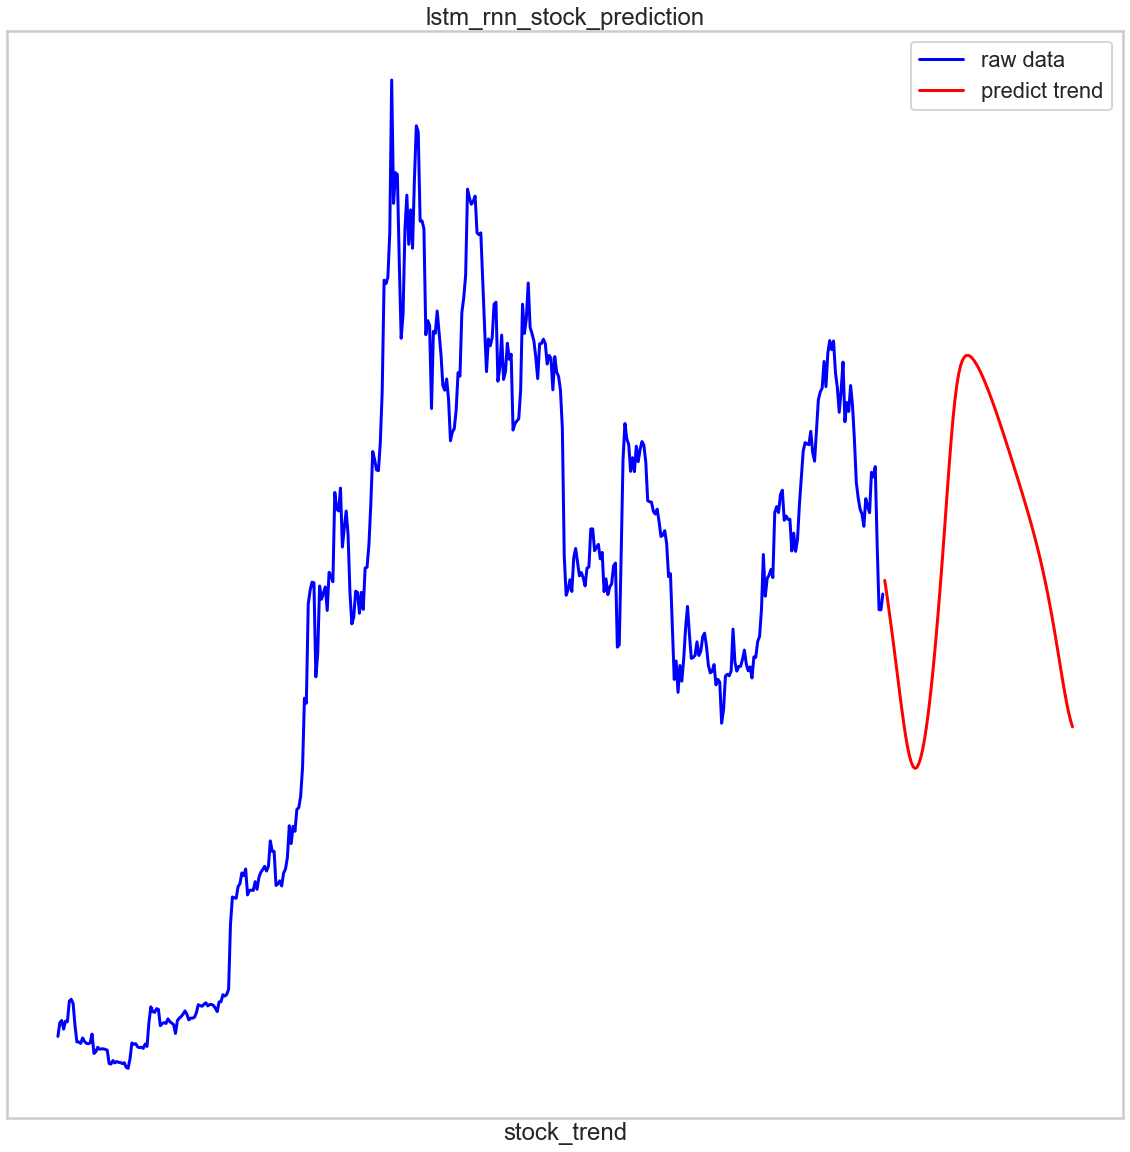

In [11]:
prediction() 

In [12]:
import tensorflow as tf

tf.__version__

'2.1.0'